<a href="https://colab.research.google.com/github/kocurvik/BCS_results/blob/master/PNNPPV/notebooky/cv09_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Cvičenie - Rekurentné siete

Na dnešnom cvičení si precvičíme prácu s rekurentnými sieťami. Vytvoríme si mierne umelý príklad, v ktorom skonštruujeme veľké číslo zo sekvencie MNIST čísel a vrátime honotu po aplikácii modula nejakým číslom (ideálne prvočíslo nad 10). 

In [1]:
import keras
from keras.datasets import mnist
from keras.layers import TimeDistributed, Conv2D, Dense, Flatten, MaxPool2D, ConvLSTM2D, GlobalAveragePooling2D, LSTM, GRU
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x, y), (x_test, y_test) = mnist.load_data()
x = x / 255
x_test = x_test / 255

11493376/11490434 [==============================] - 0s 0us/step


## Fixná sekvencia - priebežná chyba

Navrhneme si model, ktorý na začiatku bude mať konvolučné vrstvy. Potom bude mať Globálny Pooling nasledovaný GRU (gated recurrent unit) vrstvou. Tá je prepojená aj s predchádzajúcimi vrstvami v sekvencii. Nasleduje plne prepojená vrstva so softmaxom. Známejšia je vrstva LSTM, ale GRU používame pretože sa jednoduchšie trénuje. Teoreticky by LSTM malo mať dlhodobejšiu pamäť. To však nebude v našom prípade až také dôležité.

![GRU](https://raw.githubusercontent.com/kocurvik/edu/master/PNNPPV/supplementary/ntb_images/GRU_model.png)

Môžeme si vybrať ako budeme trénovať túto sieť. Na vstupe budeme mať sekvenciu obrázkov tvaru $batch \times seq \times 28 \times 28 \times 1$, kde $seq$ je dĺžka sekvencie. Na výstupe máme dve možnosti. Buď budeme sledovať len výstup na konci sekvencie a z neho rátať loss, alebo budeme trénovať sieť na všetky vstupy. Najprv otestujeme druhý prístup:

![GRU Multiloss](https://raw.githubusercontent.com/kocurvik/edu/master/PNNPPV/supplementary/ntb_images/GRU_multi_loss.png)

Model je definovaný nižšie. Wrapper `TimeDistributed` nám umožňuje zavolať nejaký druh vrsvty samostatne na po jednotlivých častiach sekvencie. Pri rekurentnej vrstve tento wrapper nepotrebujeme!

In [3]:
def build_model(modulo, seq_size):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (7,7), activation='relu'), input_shape=(seq_size, 28, 28, 1)))
  model.add(TimeDistributed(Conv2D(32, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(GlobalAveragePooling2D()))
  model.add(GRU(64, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=True))
  model.add(TimeDistributed(Dense(modulo, activation='softmax')))

  return model

Teraz bude nutné naprogramovať generátor ktorý nám dá vstupné dáta a výstupné dáta na loss. Metódu getitem doimplementujte. Na konci chceme mať klasifikáciu do `self.modulo` tried tak, že zoberieme čísla ktoré sme dávali do siete akoby sme ich postupne (zľava) zapisovali a vyrátame ich modulo našim zvoleným číslom. Defaultne 13kou.

In [4]:
class SeqDataGenerator(keras.utils.Sequence):
  def __init__(self, x, y, modulo=13, batch_size=32, seq_size=20, steps=1000):
    self.x = x
    self.y = y
    self.modulo = modulo
    self.batch_size = batch_size
    self.seq_size = seq_size
    self.steps = steps

  def __len__(self):
    return self.steps

  def __getitem__(self, index):
    X = np.empty([self.batch_size, self.seq_size, 28, 28, 1])
    y = np.zeros([self.batch_size, self.seq_size, self.modulo])

    for b in range(self.batch_size):
      sum = 0
      for s in range(self.seq_size):
        idx = np.random.randint(len(self.x))
        X[b,s,:,:,0] = self.x[idx]
        sum = sum * 10 + self.y[idx]
        y[b, s, sum % self.modulo] = 1
      #y[b, sum % self.modulo] = 1

    return X, y

Tento kód by mal potom natrénovať našu sieť na dátach. Môžete sa pohrať s nastavením dĺžky sekvencie.

In [5]:
seq_size = 10
modulo = 13

train_gen = SeqDataGenerator(x[10000:], y[10000:], modulo=modulo, batch_size=32, seq_size=seq_size)
val_gen = SeqDataGenerator(x[:10000], y[:10000], modulo=modulo, batch_size=32, seq_size=seq_size, steps=100)
model = build_model(modulo, seq_size)

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

model.fit_generator(train_gen, validation_data=val_gen, epochs=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 22, 22, 16)    800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 16, 16, 32)    25120     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 10, 10, 64)    100416    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 4, 4, 64)      200768    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 10, 64)            24960     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 13)            8

## Fixná sekvencia - Chyba len na konci

Teraz vyskúšame trénovanie tak, že chybu budeme počítať len z konca celej sekvencie.

![alt text](https://raw.githubusercontent.com/kocurvik/edu/master/PNNPPV/supplementary/ntb_images/GRU_single_loss.png)

Doimplemenujte relevantné metódy. Zistite čo robí argument `return_sequential` pri GRU vrstve a sieť upravte tak aby na výstupe bol len jeden vektor. Otestujte či trénovanie funguje a otestujte to pre rôzne dĺžky sekvencie.

In [6]:
def build_single_model(modulo, seq_size):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (7,7), activation='relu'), input_shape=(seq_size, 28, 28, 1)))
  model.add(TimeDistributed(Conv2D(32, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(GlobalAveragePooling2D()))
  model.add(GRU(64, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=False))
  model.add(Dense(modulo, activation='softmax'))

  return model

In [7]:
class SingleSeqDataGenerator(keras.utils.Sequence):
  def __init__(self, x, y, modulo=11, batch_size=32, seq_size=20, steps=1000):
    self.x = x
    self.y = y
    self.modulo = modulo
    self.batch_size = batch_size
    self.seq_size = seq_size
    self.steps = steps

  def __len__(self):
    return self.steps

  def __getitem__(self, index):
    X = np.empty([self.batch_size, self.seq_size, 28, 28, 1])
    y = np.zeros([self.batch_size, self.modulo])

    for b in range(self.batch_size):
      sum = 0
      for s in range(self.seq_size):
        idx = np.random.randint(len(self.x))
        X[b,s,:,:,0] = self.x[idx]
        sum = sum * 10 + self.y[idx]
      y[b, sum % self.modulo] = 1

    return X, y

In [8]:
seq_size = 6
modulo = 13

train_gen = SingleSeqDataGenerator(x[10000:], y[10000:], modulo=modulo, batch_size=32, seq_size=seq_size)
val_gen = SingleSeqDataGenerator(x[:10000], y[:10000], modulo=modulo, batch_size=32, seq_size=seq_size, steps=100)
single_model = build_single_model(modulo, seq_size)

opt = Adam(lr=0.001)
single_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

single_model.fit_generator(train_gen, validation_data=val_gen, epochs=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 22, 22, 16)    800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 16, 16, 32)    25120     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 10, 10, 64)    100416    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 4, 4, 64)      200768    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 10, 64)            24960     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 13)            8

## Rôzne dĺžky sekvencie

Teraz vyskúšame trénovať model vždy na inú dĺžku sekvencie. Minibatch necháme rovnaký, ale ak by sme mali problém s pamäťou tak ho môžeme redukvať. V definícii modelu, len v input shape dáme ako prvú dimenziu None

In [22]:
def build_var_model(modulo):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (7,7), activation='relu'), input_shape=(None, 28, 28, 1)))
  model.add(TimeDistributed(Conv2D(32, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(Conv2D(64, (7,7), activation='relu')))
  model.add(TimeDistributed(GlobalAveragePooling2D()))
  model.add(GRU(64, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=True))
  model.add(TimeDistributed(Dense(modulo, activation='softmax')))

  return model

Náš generátor teraz upravíme aby sme vždy vybrali náhodnú dĺžku sekvencie.

*Pozn.:* Sekvencia musí byť dĺžky aspoň 2 aby to tensorflow zvládol.

In [18]:
class VarSeqDataGenerator(keras.utils.Sequence):
  def __init__(self, x, y, modulo=11, batch_size=32, max_seq_size=20, steps=1000):
    self.x = x
    self.y = y
    self.modulo = modulo
    self.batch_size = batch_size
    self.max_seq_size = max_seq_size
    self.steps = steps

  def __len__(self):
    return self.steps

  def __getitem__(self, index):
    seq_size = np.random.randint(2, self.max_seq_size)   
    X = np.empty([self.batch_size, seq_size, 28, 28, 1]) 
    y = np.zeros([self.batch_size, seq_size, self.modulo])

    for b in range(self.batch_size):
      sum = 0
      for s in range(seq_size):
        idx = np.random.randint(len(self.x))
        X[b,s,:,:,0] = self.x[idx]
        sum = sum * 10 + self.y[idx]
        y[b, s, sum % self.modulo] = 1

    return X, y

Pri takomto prístupe ale môžeme do siete napr. pre validačné dáta poskytnúť generátor dĺžky 20.

In [35]:
max_seq_size = 20
modulo = 13

train_gen = VarSeqDataGenerator(x[10000:], y[10000:], modulo=modulo, batch_size=32, max_seq_size=max_seq_size)
val_gen = SeqDataGenerator(x[:10000], y[:10000], modulo=modulo, batch_size=32, seq_size=10, steps=100)
var_model = build_var_model(modulo)

opt = Adam(lr=0.001)
var_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(var_model.summary())

var_model.fit_generator(train_gen, validation_data=val_gen, epochs=5)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, None, 22, 22, 16)  800       
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 16, 16, 32)  25120     
_________________________________________________________________
time_distributed_33 (TimeDis (None, None, 10, 10, 64)  100416    
_________________________________________________________________
time_distributed_34 (TimeDis (None, None, 4, 4, 64)    200768    
_________________________________________________________________
time_distributed_35 (TimeDis (None, None, 64)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, None, 64)          24960     
_________________________________________________________________
time_distributed_36 (TimeDis (None, None, 13)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in long_scalars


1000/1000 [==============================] - 54s 54ms/step - loss: 2.1832 - accuracy: 0.1842 - val_loss: 2.0946 - val_accuracy: 0.2677
Epoch 2/5
1000/1000 [==============================] - 54s 54ms/step - loss: 1.8049 - accuracy: 0.2824 - val_loss: 1.9418 - val_accuracy: 0.3265
Epoch 3/5
1000/1000 [==============================] - 52s 52ms/step - loss: 1.5606 - accuracy: 0.3591 - val_loss: 1.6370 - val_accuracy: 0.4483
Epoch 4/5
1000/1000 [==============================] - 53s 53ms/step - loss: 1.2100 - accuracy: 0.5063 - val_loss: 1.0488 - val_accuracy: 0.6758
Epoch 5/5
1000/1000 [==============================] - 54s 54ms/step - loss: 0.7406 - accuracy: 0.7175 - val_loss: 0.5583 - val_accuracy: 0.8438


## Inferencia celou sekvenciou

Do posledného var modelu môžeme hodiť sekvenciu ľubovolnej dĺžky. Môžeme si tak model overiť.

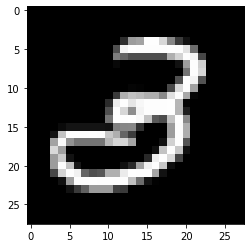

Current: 3, sum: 3, mod: 3


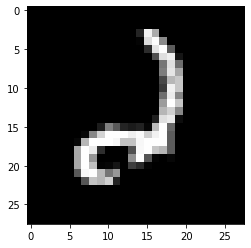

Current: 2, sum: 32, mod: 6


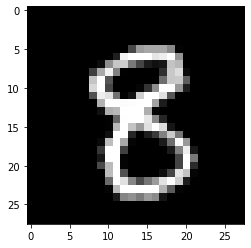

Current: 8, sum: 328, mod: 3


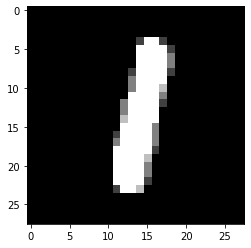

Current: 1, sum: 3281, mod: 5


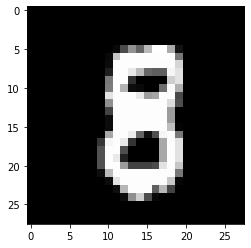

Current: 8, sum: 32818, mod: 6


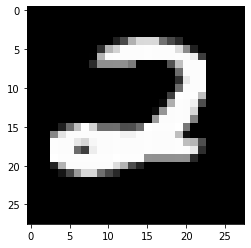

Current: 2, sum: 328182, mod: 10


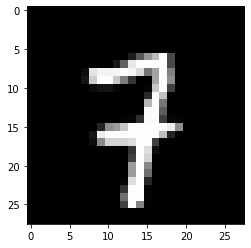

Current: 7, sum: 3281827, mod: 3


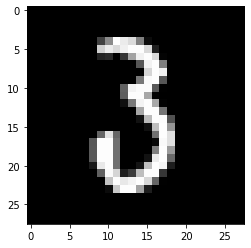

Current: 3, sum: 32818273, mod: 7


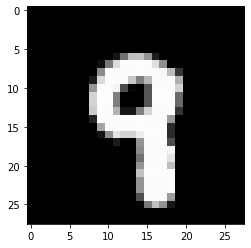

Current: 9, sum: 328182739, mod: 1


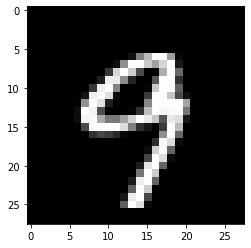

Current: 9, sum: 3281827399, mod: 6
[ 3  6  3  5  6 10  3  7  1  6]


In [36]:
seq_size = 10
X = np.empty([1, seq_size, 28, 28, 1])

sum = 0

for s in range(seq_size):
  idx = np.random.randint(10000)
  X[0, s, :, :, 0] = x_test[idx]
  sum = sum*10 + y_test[idx]
  plt.imshow(x_test[idx], cmap='gray')
  plt.show()
  print("Current: {}, sum: {}, mod: {}".format(y_test[idx], sum, sum % 13))

pred = var_model.predict(X)
pred_last = np.argmax(pred[0], axis=-1)
print(pred_last)


## Inferencia po častiach

Chceli by sme do modelu postupne vkladať obrázky a priebežne vidieť ako sa nám vyvíja modulo súčtu. Na to však musíme model upraviť na tzv. stateful. To znamená, že GRU vrsva si pamätá výstup z predchádzajúceho príkladu. Ak máme takýto stav tak pri ďalšom použití musíme model resetovať.

Na tento účel môžeme použiť šikovnú funkciu:

In [37]:
import json
from keras.models import model_from_json

def convert_to_inference_model(original_model):
    original_model_json = original_model.to_json()
    inference_model_dict = json.loads(original_model_json)
    print(inference_model_dict)

    layers = inference_model_dict['config']['layers']
    for layer in layers:
        if 'stateful' in layer['config']:
            layer['config']['stateful'] = True

        if 'batch_input_shape' in layer['config']:
            print("Did it")
            layer['config']['batch_input_shape'][0] = 1
            layer['config']['batch_input_shape'][1] = 1

    inference_model = model_from_json(json.dumps(inference_model_dict))
    inference_model.set_weights(original_model.get_weights())

    return inference_model

{'class_name': 'Sequential', 'config': {'name': 'sequential_7', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, None, 28, 28, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'time_distributed_31_input'}}, {'class_name': 'TimeDistributed', 'config': {'name': 'time_distributed_31', 'trainable': True, 'batch_input_shape': [None, None, 28, 28, 1], 'dtype': 'float32', 'layer': {'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}}}, {'class_name'

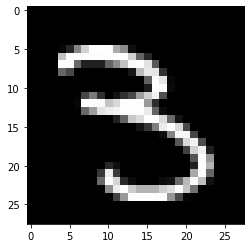

Current: 3, sum: 3, mod: 3
3


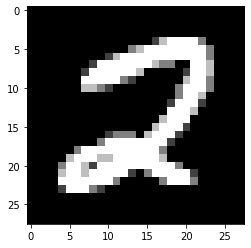

Current: 2, sum: 32, mod: 6
6


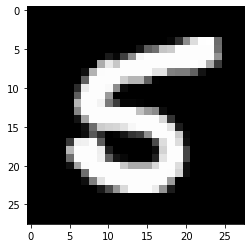

Current: 5, sum: 325, mod: 0
0


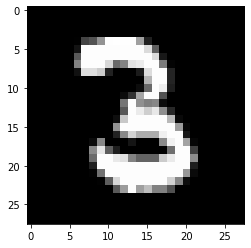

Current: 3, sum: 3253, mod: 3
3


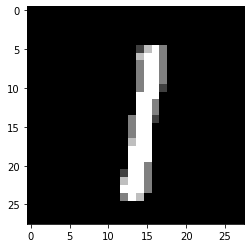

Current: 1, sum: 32531, mod: 5
5


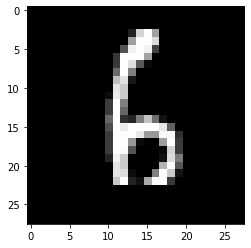

Current: 6, sum: 325316, mod: 4
4


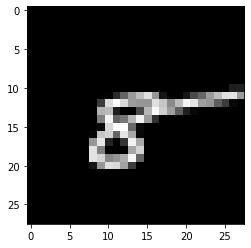

Current: 8, sum: 3253168, mod: 9
6


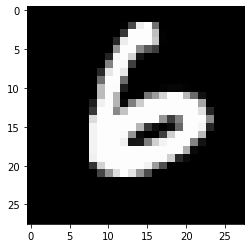

Current: 6, sum: 32531686, mod: 5
1


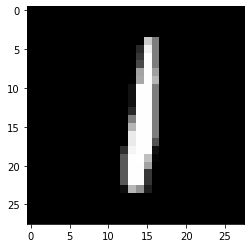

Current: 1, sum: 325316861, mod: 12
11


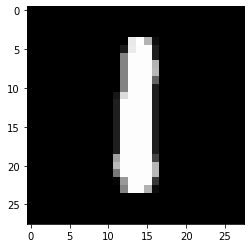

Current: 1, sum: 3253168611, mod: 4
7


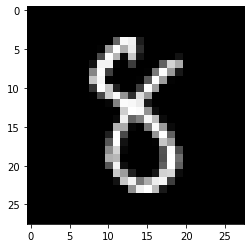

Current: 8, sum: 32531686118, mod: 9
0


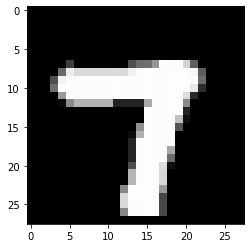

Current: 7, sum: 325316861187, mod: 6
7


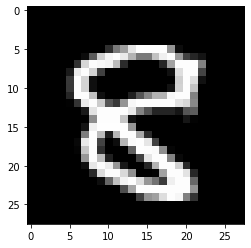

Current: 8, sum: 3253168611878, mod: 3
0


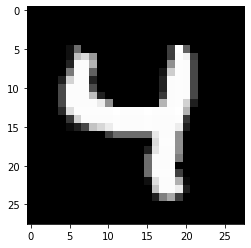

Current: 4, sum: 32531686118784, mod: 8
4


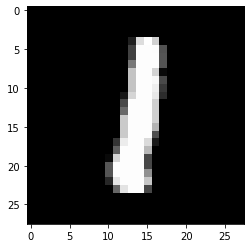

Current: 1, sum: 325316861187841, mod: 3
2


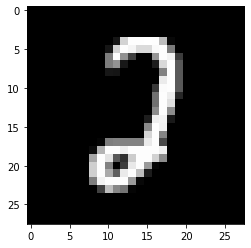

Current: 2, sum: 3253168611878412, mod: 6
9


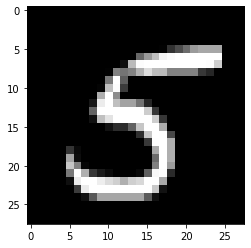

Current: 5, sum: 32531686118784125, mod: 0
4


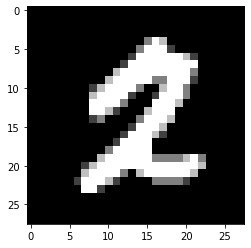

Current: 2, sum: 325316861187841252, mod: 2
3


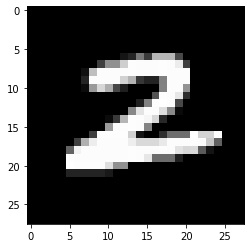

Current: 2, sum: 3253168611878412522, mod: 9
6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys


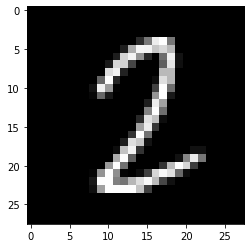

Current: 2, sum: -4361802028634978010, mod: 8
10


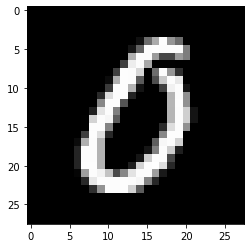

Current: 0, sum: -6724532138930676868, mod: 8
9


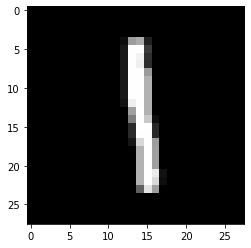

Current: 1, sum: 6541654905531437785, mod: 2
2


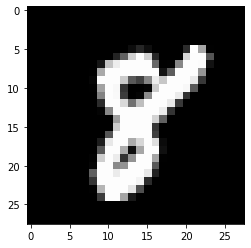

Current: 8, sum: -8370427239523828606, mod: 3
2


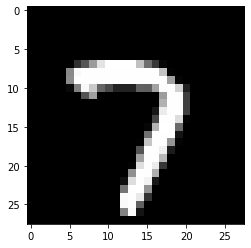

Current: 7, sum: 8529447973309472027, mod: 0
9


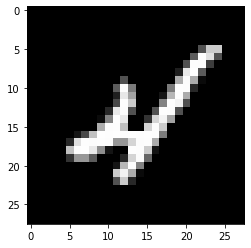

Current: 4, sum: -6939240635453037806, mod: 2
3


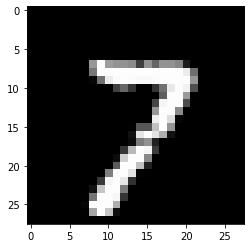

Current: 7, sum: 4394569940307828411, mod: 0
9


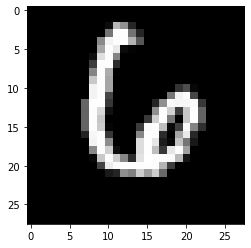

Current: 6, sum: 7052211255659180884, mod: 0
12


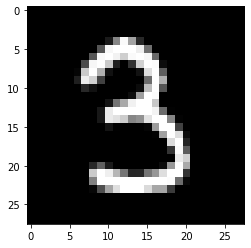

Current: 3, sum: -3264863738246397621, mod: 4
6


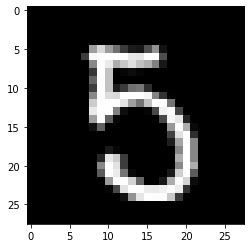

Current: 5, sum: 4244850764955127027, mod: 12
0


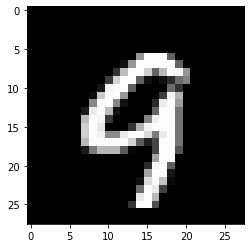

Current: 9, sum: 5555019502132167047, mod: 6
9


In [38]:
inference_model = convert_to_inference_model(var_model)

sum = 0

for s in range(30):
  idx = np.random.randint(10000)
  sum = 10 * sum + y_test[idx]
  plt.imshow(x_test[idx], cmap='gray')
  plt.show()
  print("Current: {}, sum: {}, mod: {}".format(y_test[idx], sum, sum % 13))
  predict = inference_model.predict(np.reshape(x_test[idx], [1, 1, 28, 28, 1]))
  print(np.argmax(predict[0,0]))

Ak chceme model použíť odznova, tak musíme stavy v GRU resetovať.

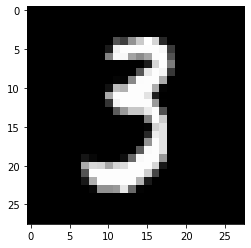

Current: 3, sum: 3, mod: 3
3


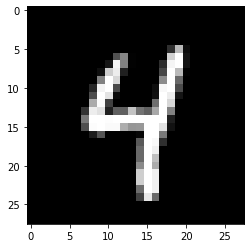

Current: 4, sum: 34, mod: 8
8


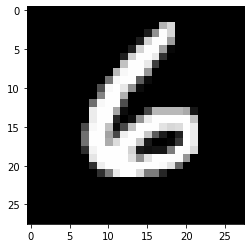

Current: 6, sum: 346, mod: 8
8


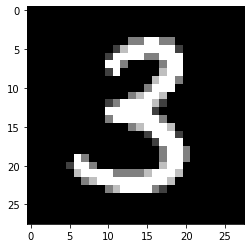

Current: 3, sum: 3463, mod: 5
5


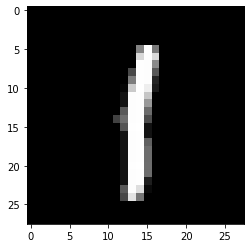

Current: 1, sum: 34631, mod: 12
1


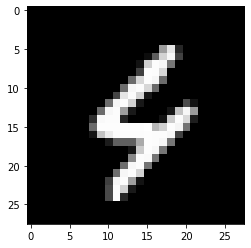

Current: 4, sum: 346314, mod: 7
1


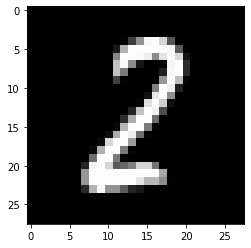

Current: 2, sum: 3463142, mod: 7
12


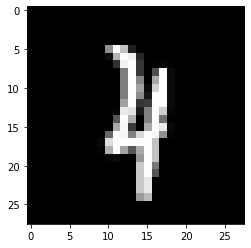

Current: 4, sum: 34631424, mod: 9
7


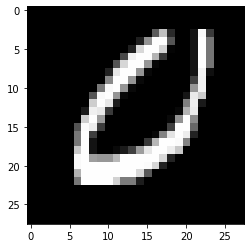

Current: 0, sum: 346314240, mod: 12
5


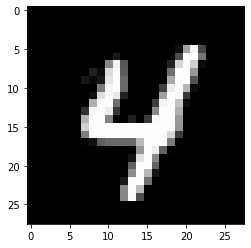

Current: 4, sum: 3463142404, mod: 7
2


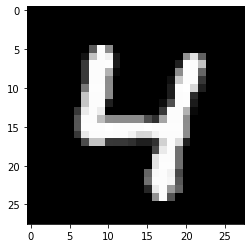

Current: 4, sum: 34631424044, mod: 9
11


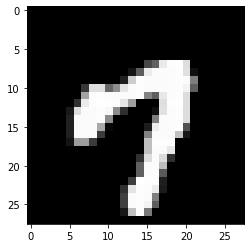

Current: 7, sum: 346314240447, mod: 6
0


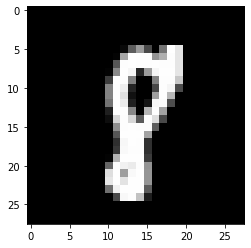

Current: 8, sum: 3463142404478, mod: 3
8


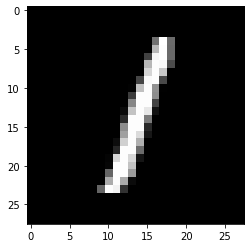

Current: 1, sum: 34631424044781, mod: 5
3


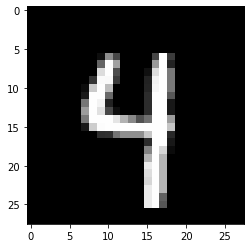

Current: 4, sum: 346314240447814, mod: 2
8


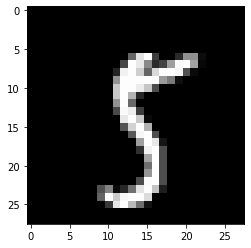

Current: 5, sum: 3463142404478145, mod: 12
7


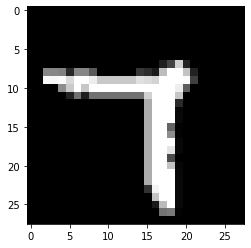

Current: 7, sum: 34631424044781457, mod: 10
1


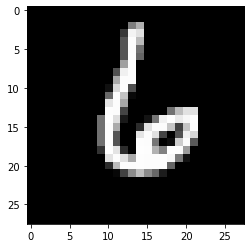

Current: 6, sum: 346314240447814576, mod: 2
3


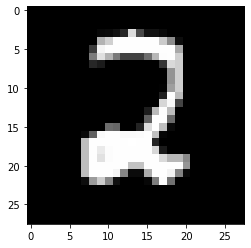

Current: 2, sum: 3463142404478145762, mod: 9
6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys


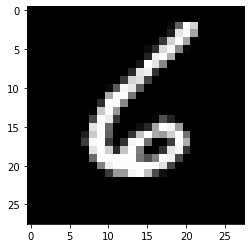

Current: 6, sum: -2262064102637645606, mod: 12
1


In [39]:
sum = 0

inference_model.reset_states()

for s in range(20):
  idx = np.random.randint(10000)
  sum = 10 * sum + y_test[idx]
  plt.imshow(x_test[idx], cmap='gray')
  plt.show()
  print("Current: {}, sum: {}, mod: {}".format(y_test[idx], sum, sum % 13))
  predict = inference_model.predict(np.reshape(x_test[idx], [1, 1, 28, 28, 1]))
  print(np.argmax(predict[0, 0]))